In [1]:
import argparse
import numpy as np
import pinocchio
from mim_control_cpp import (
    CentroidalImpedanceController
)
# %matplotlib notebook
# %matplotlib inline
import matplotlib.pylab as plt
from bullet_utils.env import BulletEnvWithGround
from robot_properties_solo.solo12wrapper import Solo12Robot, Solo12Config

import time

plt.rcParams['figure.dpi'] = 180  # makes plots bigger, default = 72.0

In [2]:
# Create a Pybullet simulation environment
env = BulletEnvWithGround()

# Create a robot instance in the simulator.
robot = Solo12Robot()
robot = env.add_robot(robot)
robot_config = Solo12Config()
mu = 0.2
kc = np.array([200, 200, 200])
dc = np.array([50, 50, 50])
kb = np.array([100, 100, 200])
db = np.array([50.0, 50.0, 200.0])
qp_penalty_weights = np.array([5e5, 5e5, 5e5, 1e6, 1e6, 1e6])

# impedance gains
kp = np.array([200, 200, 200, 0, 0, 0])
kd = np.array([10.0, 10.0, 10.0, 0, 0, 0])

pin_robot = robot.pin_robot

q_init = robot_config.q0.copy()
q_init[0] = 0.

In [3]:
import pybullet as p
obj_id = p.loadURDF("cube.urdf", [0, 0, 1])

In [4]:
p.resetBasePositionAndOrientation(
    2, [0.3, .4, 0.025], [0, 0, 0, 1]
)

# functions

In [5]:
def grf(pin_robot, q, dq, tau, grfs, forwardKs):
    pin_robot.computeJointJacobians(q)
    
    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):
        frame_id = pin_robot.model.getFrameId(endeff_name)
        pin_robot.framePlacement(q, index=frame_id)
        J = pin_robot.getFrameJacobian(frame_id=frame_id, rf_frame=pinocchio.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_inv = np.linalg.pinv(J[:3, 6 + 3 * i:9 + 3 * i].T)
        h = pin_robot.nle(q, dq)
        F = np.hstack((np.zeros(6), tau))
#         print(h.shape, F.shape)
        grfs[n, i] = J_inv @ ((h - F)[6 + 3 * i:9 + 3 * i])
    
        pin_robot.framesForwardKinematics(q)
        forwardKs[n, i] = pin_robot.data.oMf[frame_id].translation   

In [72]:
ctrl = CentroidalImpedanceController()
ctrl.initialize(2.5, np.diag(robot.pin_robot.mass(q_init)[3:6, 3:6]), pin_robot.model, "universe", 
                robot_config.end_effector_names, mu, qp_penalty_weights, kc, dc, kb, db, kp, kd
               )

# Desired center of mass position and velocity.
x_com = [0.0, 0.0, 0.35]
xd_com = [0.0, 0.0, 0.0]
# The base should be flat.
x_ori = [0.0, 0.0, 0.0, 1.0]
x_angvel = [0.0, 0.0, 0.0]

# Desired leg length
x_des = np.array([
     0.195,  0.147, 0.015, 0, 0, 0, 1.,
     0.195, -0.147, 0.015, 0, 0, 0, 1.,
    -0.195,  0.147, 0.015, 0, 0, 0, 1.,
    -0.195, -0.147, 0.015, 0, 0, 0, 1.
])
xd_des = np.zeros(4 * 6)
dur = 0.
contact_array = np.ones(4)
      
targets = None
i_targets = 0

def get_desired_position(n, grf):
    global contact_array, x_des, targets, i_targets
    contact_duration = 200
    overlap_duration = contact_duration//2
    initial_duration = 50  
    up, down = x_com[2] * 2/3 , 0.015
    points = (0, 
              contact_duration - overlap_duration, 
              contact_duration, 
              2 * contact_duration - overlap_duration,
              2 * contact_duration,
             )
    T = ((down, down, down, down), 
         (down, up, up, down),
         (up, down, down, up),
        )

    if n < initial_duration:
        contact_array = np.ones(4)
        x_des[2::7] = T[0]
        return np.ones(4, dtype=np.bool)  # not used by control loop

    t = (n - initial_duration) % (2 * contact_duration)

    if t == points[0]:
        contact_array = np.array((1, 0, 0, 1))
        targets = np.linspace(T[0], T[1], num=points[1] - points[0])
        i_targets = 0
    elif t == points[1]:
        contact_array = np.ones(4)
        targets = np.linspace(T[1], T[0], num=points[2] - points[1])
        i_targets = 0
    elif t == points[2]:
        contact_array = np.array((0, 1, 1, 0))
        targets = np.linspace(T[0], T[2], num=points[3] - points[2])
        i_targets = 0
    elif t == points[3]:
        contact_array = np.ones(4)
        targets = np.linspace(T[2], T[0], num=points[4] - points[3])
        i_targets = 0

    x_des[2::7] = targets[i_targets]
    i_targets += 1
    
    return targets[-1] == down  # whether to use grf. don't use when going up

In [46]:
N = 4000

grfs = np.empty((N, 4, 3))
contact = np.empty((N, 4))
contact_hardcoded = np.empty((N, 4))

thresholds = np.empty(N)

qs = np.empty((N, 19))
dqs = np.empty((N, 18))
forwardKs = np.empty((N, 4, 3))
desired_positions = np.empty((N, 4))
use_grfs = np.empty((N, 4))

In [73]:
robot.reset_state(q_init, robot_config.v0)

In [74]:
# Run the simulator for N steps
contact_status = np.ones(4)
p.resetBasePositionAndOrientation(
    2, [0.4, .4, 0.025], [0, 0, 0, 1]
)

use_grf = np.ones(4, dtype=np.bool)  # have to be int or bool, not float


for n in range(N):
#     if n == 1000:  # move block under FL ankle
#         p.resetBasePositionAndOrientation(
#             2, [0.2, .2, 0.025], [0, 0, 0, 1]
#         )

    q, dq = robot.get_state()
    quat = pinocchio.Quaternion(q[6], q[3], q[4], q[5])
    quat.normalize()
    
    dqs[n] = dq.copy()
    qs[n] = q.copy()
    thresholds[n] = np.sum(grfs[n-1, :, 2][grfs[n-1, :, 2] > 0])
    contact[n] = np.where((grfs[n-1, :, 2] > 1) , 1., 0.)
    contact_hardcoded[n] = contact_array.copy()
    desired_positions[n] = x_des[2::7].copy()
    use_grfs[n] = use_grf.copy()

    start = time.time()
    ctrl.run(q, dq,
#         np.array([1., 1., 1., 1.]),
        np.ones(4) if n < 50 else contact[n],
#         contact_array,
        q[:3], x_com, quat.toRotationMatrix().dot(dq[:3]), xd_com, q[3:7], x_ori, dq[3:6], x_angvel, x_des, xd_des
    )

    tau = ctrl.get_joint_torques()
    dur += time.time() - start

    robot.send_joint_command(tau)

    grf(pin_robot, q, dq, tau, grfs, forwardKs)  # and forward kinematics
    
    env.step(
#                 sleep=True
    )  # You can sleep here if you want to slow down the replay
    
    use_grf = get_desired_position(n, grfs[n])
    
print('Control path: %0.3f ms' % (dur * 1000. / N))

Control path: 0.070 ms


In [14]:
grfs.shape

(1100, 4, 3)

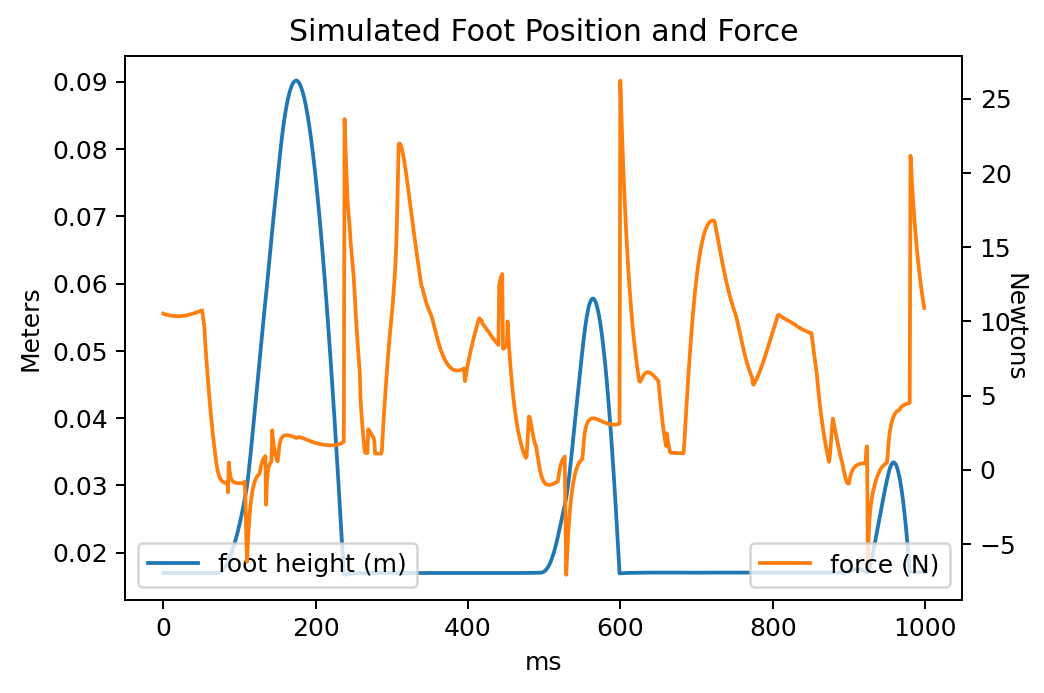

In [75]:
s = slice(1200, 2200)

plt.plot(forwardKs[s, 2, 2], color='C0', label='foot height (m)')
plt.ylabel('Meters')
plt.xlabel('ms')

plt.legend(loc='lower left')
t = plt.twinx()
t.plot(grfs[s, 2, 2], color='C1', label='force (N)')
t.set_ylabel('Newtons', rotation=270)
t.legend(loc='lower right')

plt.title("Simulated Foot Position and Force")

plt.show()

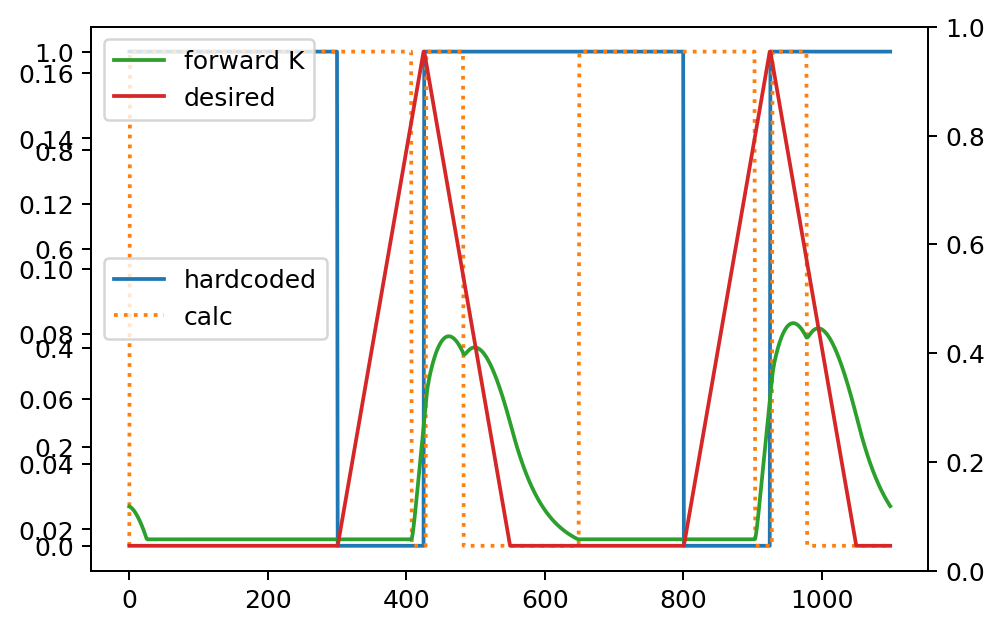

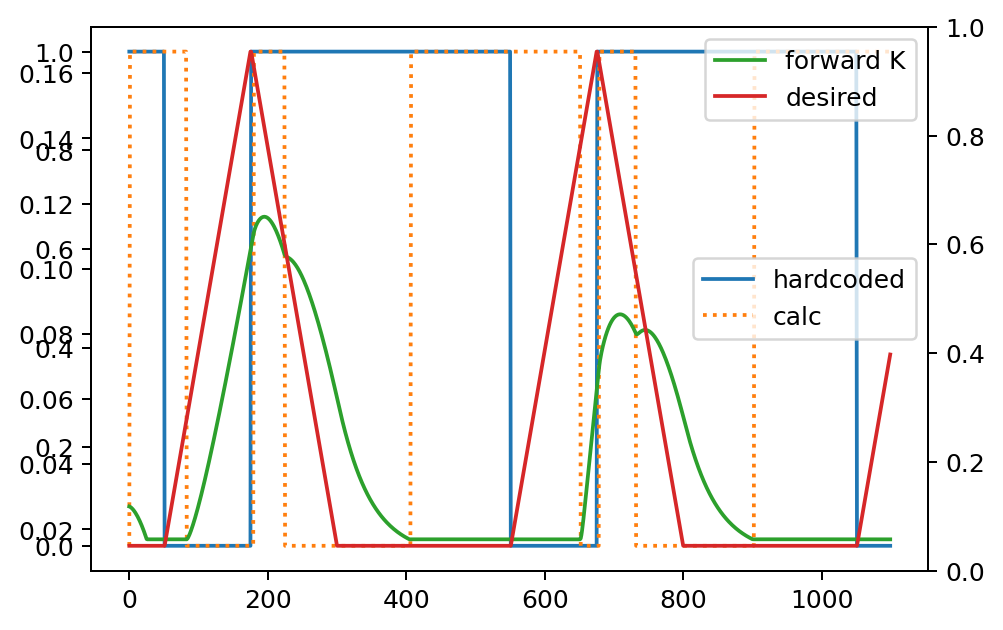

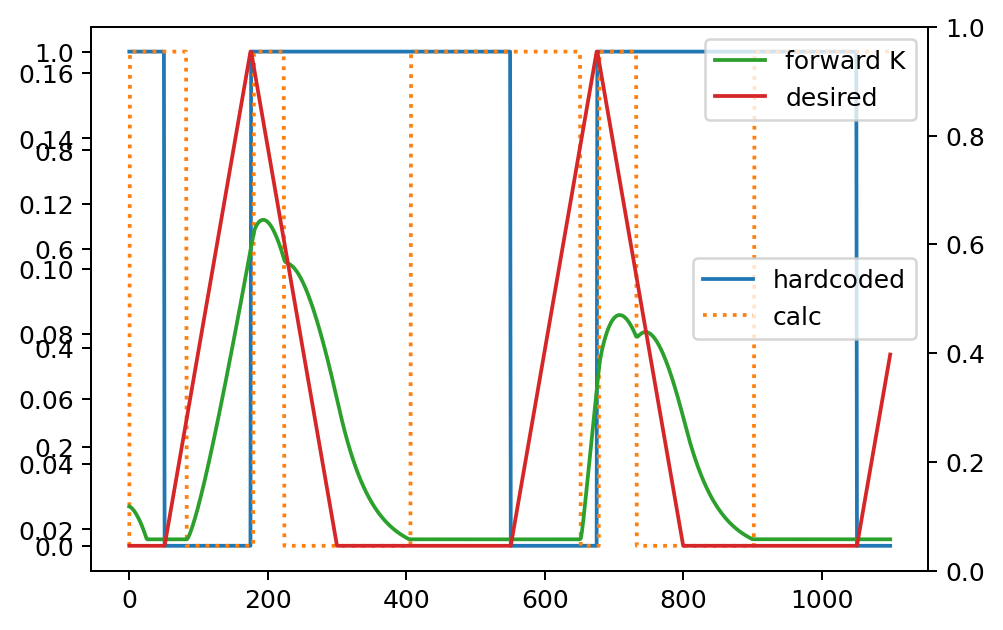

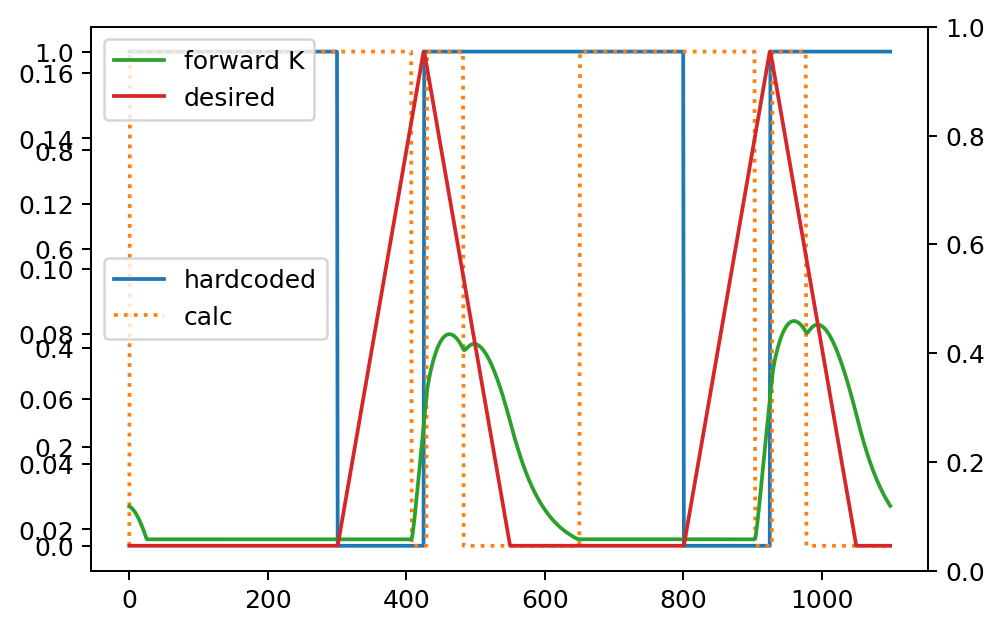

In [10]:
s = slice(0, 2000)
# s = slice(-1)
for i in range(4):
    plt.plot(contact_hardcoded[s, i], label='hardcoded', color='C0')
    plt.plot(contact[s, i], ':', label='calc', color="C1")
#     plt.plot(use_grfs[s, i], '--', label='use_grf', color='C5')
    plt.legend()
    
    t = plt.twinx()
    t.plot(forwardKs[s, i, 2], label='forward K', color='C2')
    t.plot(desired_positions[s, i], label='desired', color='C3')
    t.legend()
    
    w = plt.twinx()
#     w.plot(grfs[s, i, 2], color="C3", label='grf')
#     w.axhline(1)
#     w.plot(thresholds[s], color="C4", label='sum')
#     w.plot(dqs[s, 8 + 3 * i], color='C5', label='vel')
#     w.legend(loc="lower left")
    plt.show()